In [1]:
import matplotlib.pyplot as plt

import configs as cf
from preprocess import *
from network import *
from train_tts import *
from text_to_speech import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set Dataset
full_ds = get_single_speaker_dataset(
    cf.SPEAKER, cf.WAV_PATH, cf.SCRIPT_FILE_NAME,
    cf.SR, cf.N_MELS, cf.N_FFT, cf.HOP_LENGTH, cf.WIN_LENGTH
)

full_dl = get_dl_by_ds(full_ds, cf.BATCH_SIZE, cf.DL_NUM_WORKERS, shuffle=True)

Loading ['여1_소설1', '여1_자기계발2', '여1_동화1', '여1_자기계발1'] ...
소설1 Done!
자기계발2 Done!
동화1 Done!
자기계발1 Done!


In [4]:
MODEL_FILE_PATH = './model/single_speaker_tts_best.pt'

model = torch.load(MODEL_FILE_PATH).to(device)

In [5]:
# model = Transformer(
#     len(cf.ALL_SYMBOLS), cf.N_MELS, cf.N_LAYERS, cf.HIDDEN_DIM,
#     cf.N_HEADS, cf.PF_DIM, cf.TEXT_SEQ_LEN, cf.SPEECH_SEQ_LEN,
#     cf.PAD_IDX, cf.DROPOUT_RATIO, device
# ).to(device)
# model.eval()

In [6]:
batch = iter(full_dl).next()
tensor_dict_to_device(batch, device)

In [7]:
mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

query: torch.Size([8, 8, 106, 32])
tensor([[ -8.3454, -44.9314,  -7.3284,  ...,  12.4718, -11.2240,  15.5270],
        [ -3.6423, -30.7496,  17.4633,  ...,  34.2213,   7.7943,  -7.5456],
        [ -2.2863, -13.8413,  14.3327,  ...,  23.2200,   1.7974,  -8.5804],
        ...,
        [ 19.5492,  -3.6913,  -0.6544,  ...,  25.5471,   2.2020,  -1.7114],
        [ 19.3189, -10.0744,   8.9756,  ...,   1.6549,   1.5036,   7.4775],
        [ 15.9913,  -9.8981,   3.2816,  ...,   6.3276,   1.4942,   8.8021]],
       device='cuda:0', grad_fn=<SelectBackward0>)

key: torch.Size([8, 8, 106, 32])
tensor([[ -7.6183,  -1.7652, -10.2989,  ...,  -2.5979,  -5.5210, -32.9835],
        [ 20.9989,  -8.7349, -13.2053,  ..., -17.7996,  23.1944, -10.9552],
        [-13.2560,  -6.0619, -13.5297,  ..., -29.6389,  -5.4020, -25.1458],
        ...,
        [ -0.2353,   4.8784,   9.1038,  ...,   0.7884, -16.4934,  -9.2961],
        [ -0.6288,  11.8670,  -2.7953,  ...,  -9.4550,  -1.5306,  -5.0695],
        [  4.5454

In [8]:
cf.id_to_char[batch['text_tokens'][0][45].item()]

'_'

In [9]:
''.join([cf.id_to_char[_] for _ in batch['text_tokens'][0].detach().cpu().numpy()])

'@토끼와 늑대|____________________________________________________________________________________________'

In [16]:
enc_attention[0][0][0][0]

tensor([0.0000e+00, 0.0000e+00, 7.7483e-15, 5.8412e-17, 0.0000e+00, 0.0000e+00,
        1.6410e-34, 0.0000e+00, 1.4271e-07, 9.8463e-01, 1.5372e-02, 4.2891e-22,
        6.9977e-37, 1.1288e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [10]:
torch.max(enc_attention[0][0][0], axis=-1)

torch.return_types.max(
values=tensor([0.9846, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 0.9978, 0.9921, 0.7370,
        0.9863, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9988, 1.0000, 1.0000, 0.9993, 1.0000],
       device='cuda:0', 

In [11]:
# Random으로 테스트

# batch = {
#     'text_tokens': torch.randint(1, 40, (8, 64)),
#     'mel': torch.rand(8, 275, 80)
# }
# tensor_dict_to_device(batch, device)
# mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

In [12]:
# attention의 query, key, value가 seq에 따라 다르지 않고 모두 똑같은 현상이 있음.
# layer stack이 쌓임에 따라서 output에 가까운 attention일수록 더욱 더 똑같아짐.
# 이렇게 작동하는 가장 큰 이유는 output에서 가장 먼 attention(첫번째 encoder의 attention)의 결과가 query, key가 어떻든 관계없이 하나는 1, 나머지는 0인데 그 1의 위치마저 모두 같음.
# 모델 최초 init에서는 정상적으로 random함. 하지만 학습과정에서 이렇게 유도되는 듯 하다. 이유를 모르겠다.
# chatbot에서는 어땠는지 확인하는게 좋을듯.

In [13]:
i = 1

print(enc_energy[0][0][0][i])
print(torch.softmax(enc_energy[0][0][0][i], axis=-1))

tensor([-2.5890e+01, -6.0219e+01,  7.9605e+01,  2.1846e-01, -7.5795e+01,
         2.5672e+01,  6.0241e+01,  5.2996e+01, -2.5090e+01,  1.6382e+02,
         5.2779e+01,  8.2321e+01, -5.8368e+01,  1.0695e+02, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0

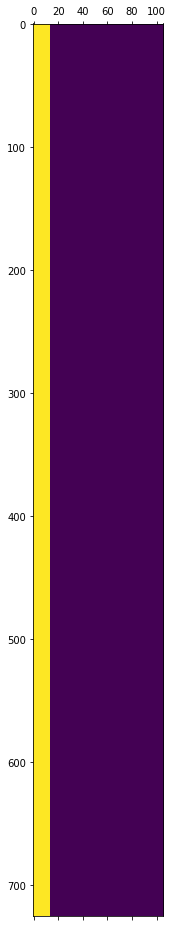

In [14]:
plt.matshow(attention[0][0][0].detach().cpu().numpy())